In [24]:
import requests
import pandas as pd
from datetime import datetime, timedelta


base_url = "https://stablecoinstats.com/api/historical/"
stablecoins = ["USDT", "USDC", "DAI"]

# Define the date range for historical data
today = datetime.today()
start_date = datetime(2024, 2, 2)  # Adjust start_date as needed

# Create an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through each date and stablecoin
for date in pd.date_range(start_date, today):
    date_str = date.strftime("%Y-%m-%d")
    for stablecoin in stablecoins:
        try:
            url = f"{base_url}{date_str}/{stablecoin}"
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for non-200 status codes

            # Extract the relevant data from the response
            daily_data = response.json()
            print(daily_data)
            daily_data["date"] = date
            daily_data["symbol"] = stablecoin
            # Convert dictionary to Series and append to DataFrame
            data = pd.concat([data, pd.Series(daily_data).to_frame().T], ignore_index=True)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {stablecoin} on {date}: {e}")

# Print or save the DataFrame


{'circulation': 94440280775.0643, 'circulation_change_24h': 8472236.100006104, 'circulation_percent_change_24h': 0.008971803284388336, 'name': 'Tether USD', 'price': 1.0287089401448193, 'price_percent_change_24h': 0.508460177356884, 'symbol': 'USDT', 'treasury': {'erc20_balance': 781623677.971909, 'erc20_supply': 44005847706.82894, 'omni_balance': 701804198.9564385, 'omni_supply': 888000000.0, 'quarantined_balance': 31304655, 'trc20_supply': 51819943510.921936, 'tron_balance': 758777910.758233}, 'volume': 3218788482.462179, 'volume_change_24h': -688177324.6050096, 'volume_percent_change_24h': -17.61411178362982}
{'circulation': 23488981291.828255, 'circulation_change_24h': 145345551.30736923, 'circulation_percent_change_24h': 0.6226345926700363, 'name': 'USD Coin', 'price': 1.0015049490191055, 'price_percent_change_24h': -0.025763883033569326, 'symbol': 'USDC', 'volume': 649454568.2508984, 'volume_change_24h': -111104383.6645714, 'volume_percent_change_24h': -14.60825401959371}
{'circu

{'circulation': 24216558944.23494, 'circulation_change_24h': 268212098.49206924, 'circulation_percent_change_24h': 1.1199608065629274, 'name': 'USD Coin', 'price': 1.0012580957558812, 'price_percent_change_24h': 0.0568500382524447, 'symbol': 'USDC', 'volume': 841090586.9585977, 'volume_change_24h': 37210721.56155753, 'volume_percent_change_24h': 4.628890853383792}
{'circulation': 3635089099.9141154, 'circulation_change_24h': -802397.0137195587, 'circulation_percent_change_24h': -0.022068783251578, 'name': 'Dai', 'price': 1.0050354026888366, 'price_percent_change_24h': 0.12512295253040176, 'symbol': 'DAI', 'volume': 9654085.533832397, 'volume_change_24h': 236049.52882578224, 'volume_percent_change_24h': 2.5063561946492734}
{'circulation': 94420192600.6543, 'circulation_change_24h': 5000000.0, 'circulation_percent_change_24h': 0.005295757877811447, 'name': 'Tether USD', 'price': 1.0165222124100668, 'price_percent_change_24h': -0.47990201546387906, 'symbol': 'USDT', 'treasury': {'erc20_ba

{'circulation': 95395725462.5143, 'circulation_change_24h': 279457142.8600006, 'circulation_percent_change_24h': 0.29380583132302635, 'name': 'Tether USD', 'price': 1.022752751361988, 'price_percent_change_24h': -0.11850086466772798, 'symbol': 'USDT', 'treasury': {'erc20_balance': 292616522.221909, 'erc20_supply': 44005847706.82894, 'omni_balance': 701804198.9564385, 'omni_supply': 888000000.0, 'quarantined_balance': 31304655, 'trc20_supply': 51819252976.74034, 'tron_balance': 291649844.876641}, 'volume': 6486445966.121647, 'volume_change_24h': 220117975.09679794, 'volume_percent_change_24h': 3.512710720091081}
{'circulation': 24453731548.301167, 'circulation_change_24h': 21615495.451251984, 'circulation_percent_change_24h': 0.08847164692773558, 'name': 'USD Coin', 'price': 1.0014431099743704, 'price_percent_change_24h': -0.08122236886903068, 'symbol': 'USDC', 'volume': 804783652.784251, 'volume_change_24h': 124877770.00834417, 'volume_percent_change_24h': 18.366920065244262}
{'circula

{'circulation': 3684413207.1391826, 'circulation_change_24h': -281373.1618323326, 'circulation_percent_change_24h': -0.0076362682360866475, 'name': 'Dai', 'price': 1.0016585553417021, 'price_percent_change_24h': -0.43511006100239574, 'symbol': 'DAI', 'volume': 25472981.59306651, 'volume_change_24h': 9902651.19082432, 'volume_percent_change_24h': 63.59949297799293}
{'circulation': 96033224426.83429, 'circulation_change_24h': 66459440.55999756, 'circulation_percent_change_24h': 0.06925255901822153, 'name': 'Tether USD', 'price': 1.0251505991666034, 'price_percent_change_24h': -0.005075952822709593, 'symbol': 'USDT', 'treasury': {'erc20_balance': 886056522.221909, 'erc20_supply': 45005847706.82894, 'omni_balance': 701804198.9564385, 'omni_supply': 888000000.0, 'quarantined_balance': 31304655, 'trc20_supply': 51819252976.74034, 'tron_balance': 60710880.556641}, 'volume': 5762724121.054986, 'volume_change_24h': -247710445.45370865, 'volume_percent_change_24h': -4.121340024796197}
{'circulat

In [25]:
df = data

In [26]:
# Ensure 'price' and 'volume' are numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

# Group by 'symbol' and then apply rolling window calculations
# This ensures calculations are done per stablecoin

# Moving Averages for price, grouped by symbol
df['price_ma7'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=7).mean())
df['price_ma30'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=30).mean())

# Moving Averages for volume, grouped by symbol
df['volume_ma7'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=7).mean())
df['volume_ma30'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=30).mean())

# Volatility Indices: Price standard deviation over the dataset (simplified example), grouped by symbol
df['price_std'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=3).std())

# Example of handling missing values by forward filling (use cautiously)
# It's applied globally here, but you might want to consider handling missing values within each group separately
df.fillna(method='ffill', inplace=True)

# Normalization (Min-Max scaling)
# Ensure this is appropriate for your use case, especially when applied after grouping
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# If you need to scale within each group, you'll have to apply the scaler within a groupby operation
df[['circulation', 'volume']] = scaler.fit_transform(df[['circulation', 'volume']])


In [32]:
dict_df = pd.json_normalize(df['treasury'])
df = pd.concat([df.drop(columns=['treasury']), dict_df], axis=1)


In [33]:
df

,circulation,circulation_change_24h,circulation_percent_change_24h,name,price,price_percent_change_24h,symbol,volume,volume_change_24h,volume_percent_change_24h,...,volume_ma7,volume_ma30,price_std,erc20_balance,erc20_supply,omni_balance,omni_supply,quarantined_balance,trc20_supply,tron_balance
0,0.982045,8.472236e+06,0.008972,Tether USD,1.028709,0.508460,USDT,0.462807,-6.881773e+08,-17.614112,...,NaN,NaN,NaN,7.816237e+08,4.400585e+10,7.018042e+08,888000000.0,31304655,5.181994e+10,7.587779e+08
1,0.214802,1.453456e+08,0.622635,USD Coin,1.001505,-0.025764,USDC,0.092889,-1.111044e+08,-14.608254,...,NaN,NaN,NaN,7.816237e+08,4.400585e+10,7.018042e+08,888000000.0,31304655,5.181994e+10,7.587779e+08
2,0.000326,-1.315085e+07,-0.358496,Dai,1.002823,-0.329532,DAI,0.001359,3.709629e+06,37.086304,...,NaN,NaN,NaN,7.816237e+08,4.400585e+10,7.018042e+08,888000000.0,31304655,5.181994e+10,7.587779e+08
3,0.982045,0.000000e+00,0.000000,Tether USD,1.059764,3.026804,USDT,0.210565,-1.754522e+09,-54.466038,...,NaN,NaN,NaN,7.816237e+08,4.400585e+10,7.018042e+08,888000000.0,31304655,5.181994e+10,7.587779e+08
4,0.215407,5.459892e+07,0.232431,USD Coin,1.003399,0.166784,USDC,0.030362,-4.262462e+08,-66.455156,...,NaN,NaN,NaN,7.816237e+08,4.400585e+10,7.018042e+08,888000000.0,31304655,5.181994e+10,7.587779e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.225379,7.688106e+07,0.315212,USD Coin,1.000425,-0.053875,USDC,0.109134,-1.532599e+08,-16.739683,...,6.145015e+08,NaN,0.000604,8.859466e+08,4.500585e+10,7.018042e+08,888000000.0,31304655,5.281925e+10,9.933732e+08
65,0.000562,1.852469e+07,0.506345,Dai,1.003114,0.184687,DAI,0.001104,-5.171912e+06,-30.214514,...,1.361384e+07,NaN,0.000835,8.859466e+08,4.500585e+10,7.018042e+08,888000000.0,31304655,5.281925e+10,9.933732e+08
66,0.000562,1.852469e+07,0.506345,Dai,1.003114,0.184687,USDT,0.001104,-5.171912e+06,-30.214514,...,1.361384e+07,NaN,0.000835,8.859466e+08,4.500585e+10,7.018042e+08,888000000.0,31304655,5.281925e+10,9.933732e+08
67,0.000562,1.852469e+07,0.506345,Dai,1.003114,0.184687,USDC,0.001104,-5.171912e+06,-30.214514,...,1.361384e+07,NaN,0.000835,8.859466e+08,4.500585e+10,7.018042e+08,888000000.0,31304655,5.281925e+10,9.933732e+08


In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

df_enhanced = df
# Enhanced Data Preprocessing and Feature Engineering
# Note: For simplicity, we're directly using the new features without additional engineering in this example.
features = df_enhanced[['price', 'price_percent_change_24h', 'volume', 'volume_change_24h', 'volume_percent_change_24h']]
scaled_features = scaler.fit_transform(features)

# Model Initialization with Hyperparameter Tuning
# Note: Due to the demonstration nature, we're using predefined parameters.
model_enhanced = OneClassSVM(kernel="rbf", gamma='auto')
parameters = {'nu': [0.01, 0.05, 0.1]}

# Splitting data into training and testing sets for evaluation purposes
# Note: In a real-world scenario, especially for unsupervised tasks like anomaly detection, this step might differ.
X_train, X_test = train_test_split(scaled_features, test_size=0.3, random_state=42)

# Grid Search for parameter tuning (simulated here as we only use OneClassSVM without GridSearchCV due to its unsupervised nature)
model_enhanced.fit(X_train)

# Predicting anomalies on the test set
predictions_enhanced = model_enhanced.predict(X_test)
anomalies_enhanced = X_test[predictions_enhanced == -1]

anomalies_enhanced

array([[1.61123570e-01, 4.35930941e-01, 0.00000000e+00, 5.74934077e-01,
        3.66635842e-02],
       [5.21671463e-02, 3.92785110e-01, 3.03617657e-02, 5.17271113e-01,
        0.00000000e+00],
       [7.98188983e-02, 1.71290641e-01, 1.46681520e-03, 5.76873373e-01,
        8.85623997e-01],
       [1.90633622e-02, 3.18223361e-01, 9.06981061e-02, 6.28507492e-01,
        1.00000000e+00],
       [3.40178560e-01, 3.26843050e-01, 8.87486954e-01, 5.81570314e-01,
        3.04701838e-01],
       [0.00000000e+00, 3.15855480e-01, 1.08455068e-01, 6.30198270e-01,
        8.00599074e-01],
       [4.41639636e-01, 0.00000000e+00, 4.62495833e-01, 7.57967643e-01,
        6.20630470e-01],
       [2.29030275e-02, 2.64996220e-01, 3.05203139e-03, 5.77115367e-01,
        5.90168016e-01],
       [2.01316846e-01, 5.52606357e-01, 4.09641103e-04, 5.74877201e-01,
        8.65865851e-02],
       [4.73745384e-02, 3.96586160e-01, 1.10441002e-03, 5.75046977e-01,
        1.64454467e-01],
       [3.27821002e-01, 7.5200

In [80]:
# Assuming 'price' is a feature in your dataset and scaled_features is derived from it
# Reverse scaling to get original price values for label simulation
original_prices = scaler.inverse_transform(X_test)[:, 0]  # Assuming 'price' is the first feature

# Generate true labels based on the price being within 1 ± 0.10
true_labels_test = np.where((original_prices >= 0.90) & (original_prices <= 1.10), 0, 1)

# The mapping of predictions remains the same
mapped_predictions_enhanced = np.where(predictions_enhanced == -1, 1, 0)

# Calculate and print the classification report
report = classification_report(true_labels_test, mapped_predictions_enhanced, target_names=['Normal', 'Anomaly'])
print(report)


              precision    recall  f1-score   support

      Normal       1.00      0.38      0.55        21
     Anomaly       0.00      0.00      0.00         0

    accuracy                           0.38        21
   macro avg       0.50      0.19      0.28        21
weighted avg       1.00      0.38      0.55        21



/Users/peter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
true_labels_test,  mapped_predictions_enhanced

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]))

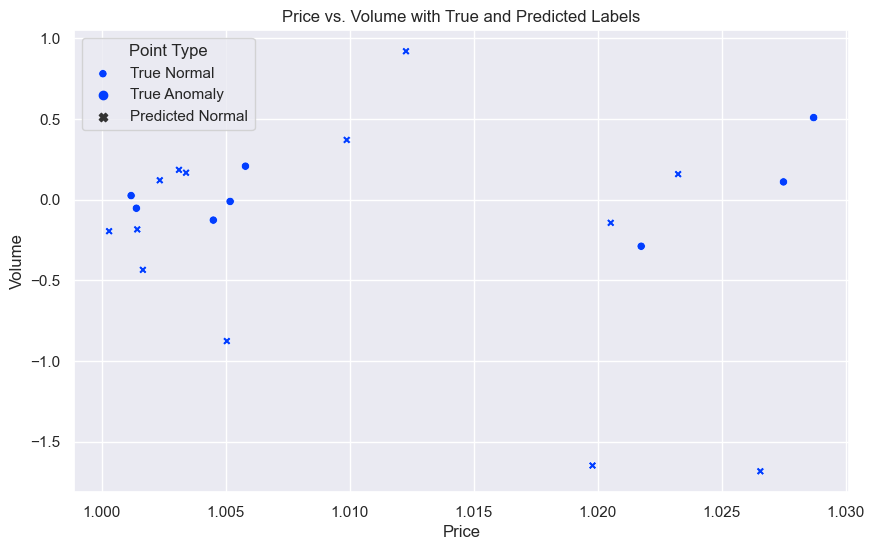

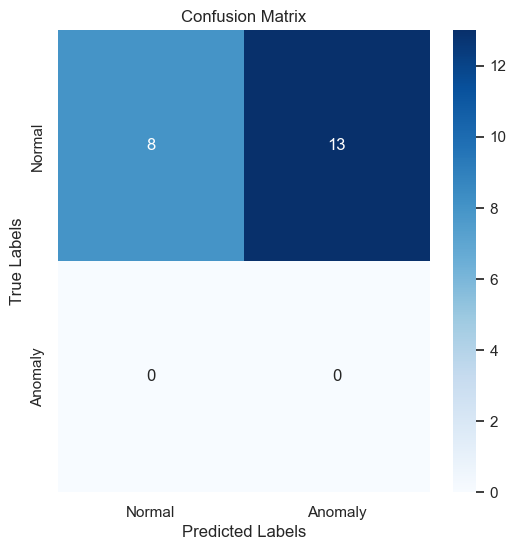

In [75]:
from sklearn.metrics import confusion_matrix

# Scatter Plot - Assuming 'price' and 'volume' are the first two features for visualization
# Reverse scaling for visualization purposes
original_features = scaler.inverse_transform(X_test)
original_prices = original_features[:, 0]  # Assuming 'price' is the first feature
original_volumes = original_features[:, 1]  # Assuming 'volume' is the second feature for demonstration

plt.figure(figsize=(10, 6))
sns.scatterplot(x=original_prices, y=original_volumes, hue=true_labels_test, style=mapped_predictions_enhanced, palette="bright")
plt.title('Price vs. Volume with True and Predicted Labels')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.legend(title='Point Type', labels=['True Normal', 'True Anomaly', 'Predicted Normal', 'Predicted Anomaly'])
plt.grid(True)
plt.show()

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(true_labels_test, mapped_predictions_enhanced)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


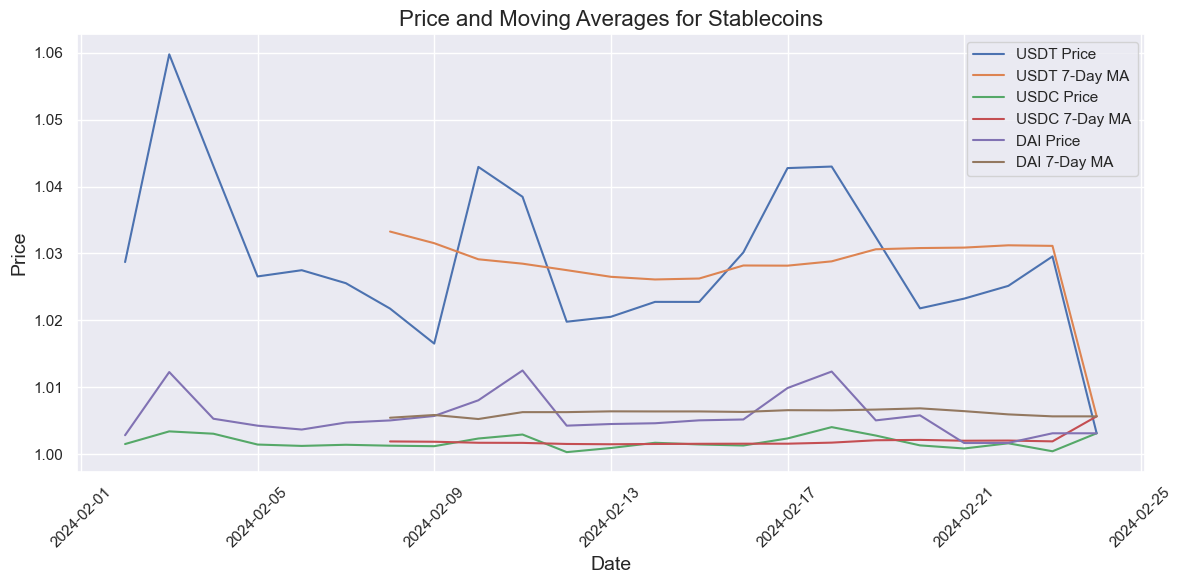

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

# Plotting with seaborn
plt.figure(figsize=(12, 6))

# Plotting each symbol with seaborn lineplot
for symbol in df['symbol'].unique():
    subset = df[df['symbol'] == symbol]
    sns.lineplot(x='date', y='price', data=subset, label=f"{symbol} Price")
    sns.lineplot(x='date', y='price_ma7', data=subset, label=f"{symbol} 7-Day MA")

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Price and Moving Averages for Stablecoins', fontsize=16)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()